In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model, create_model_bn, create_model_pruned, 
                       create_model_sequential, create_model_sequential_bn,
                       lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.19.2


In [2]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.29)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.19.npz ...
[INFO    ] Loaded the variables with shape (3273895, 87)
[INFO    ] Loaded the parameters with shape (3273895, 3)
[INFO    ] Loaded the encoded variables with shape (3273895, 50)
[INFO    ] Loaded the encoded parameters with shape (3273895,)
[INFO    ] Loaded # of training and testing events: (2324465, 949430)


In [3]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=131)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd.19.npz ...
[INFO    ] Loaded the variables with shape (650500, 87)
[INFO    ] Loaded the auxiliary PU info with shape (650500, 4)
[INFO    ] Loaded the encoded variables with shape (650500, 50)
[INFO    ] Loaded the encoded auxiliary PU info with shape (650500, 4)
[INFO    ] Loaded # of training and testing events: (520633, 129867)


### Training

In [4]:
# Hello, what do you want to train today?

training_seq    = False
training_func   = False
training_bn     = False
training_pruned = False

In [5]:
# Training (Sequential)
# 'model_seq' is a densely connected NN with 3 hidden layers and 1 output node

if training_seq:
  assert(keras.backend.backend() == 'tensorflow')
  
  model_seq = create_model_sequential(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg)

  history = train_model(model_seq, x_train, y_train[0] if isinstance(y_train, list) else y_train, 
                        model_name='model', epochs=200, batch_size=256,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

In [6]:
# Training (Functional)
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

if training_func:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut, tile=5)
  else:
    raise Exception('add_noise must be set to True')
    
  model = create_model(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight)

  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=300, batch_size=256,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [7]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

if training_bn:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut, tile=5)
  else:
    raise Exception('add_noise must be set to True')
  
  model = create_model_bn(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                          nodes1=50, nodes2=30, nodes3=20)
  
  logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
  
  normal_epochs = 300
  normal_batch_size = 256*4*2
  
  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=normal_epochs, batch_size=normal_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [8]:
# Training (with Pruning)
# 1. First training: do the same thing as 'Training (Functional)', but with l1_reg and large batch_size.
# 2. Apply pruning
# 3. Retraining with pruned model, repeat the same thing as 'Training (Functional)'

if training_pruned:
  assert(keras.backend.backend() == 'tensorflow')
  
  # First training
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut, tile=5)
  else:
    raise Exception('add_noise must be set to True')
  
  #l1_reg = 1e-4
  l1_reg = 5e-06
  model = create_model(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                       nodes1=40, nodes2=30, nodes3=20)
  
  logger.info('Training model with l1_reg: {0}'.format(l1_reg))
  
  small_epochs = 80
  large_batch_size = 4096
  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=small_epochs, batch_size=large_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [9]:
if training_pruned:
  
  # Apply pruning
  from nn_models import clone_model
  model_unpruned = clone_model(model)  # deep copy
  model_unpruned.set_weights(model.get_weights())

  pruning_percentile = 20.
  pruned = prune_model(model, percentile=pruning_percentile)
  (weightsPerLayer, droppedPerLayer, binaryTensorPerLayer, allWeightsByLayer, allWeightsArray) = pruned

In [10]:
if training_pruned:
  
  # Check pruning
  #percentiles = [5.,pruning_percentile,95.]
  #colors = ['r','g','r']
  percentiles = [10,20,30,40,50,60,70,80,90]
  colors = ['r','r','r','r','r','r','r','r','r']
  vlines = np.percentile(allWeightsArray,percentiles,axis=-1)

  #xmin = np.min(allWeightsArray[np.nonzero(allWeightsArray)])
  #xmax = np.max(allWeightsArray)
  xmin = 1e-7
  xmax = 1
  bins = np.linspace(xmin, xmax, 50)
  logbins = np.geomspace(xmin, xmax, 50)

  #plt.figure()
  #sorted_items = sorted(allWeightsByLayer.items())
  #plt.hist([v for k, v in sorted_items],bins=logbins,histtype='bar',stacked=True,label=[k for k, v in sorted_items])
  #plt.legend(prop={'size':10}, loc='upper right')
  #axis = plt.gca()
  #ymin, ymax = axis.get_ylim()
  #for vline, percentile, color in zip(vlines, percentiles, colors):
  #  if percentile==0: continue
  #  if vline < xmin: continue
  #  plt.axvline(vline, 0, 1, color=color, linestyle='dashed', linewidth=1, label='%s%%'%percentile)
  #  plt.text(vline, ymax+0.01*(ymax-ymin), '%s%%'%percentile, color=color, horizontalalignment='center')
  #plt.ylabel('Number of Weights')
  #plt.xlabel('Absolute Relative Weights')
  #plt.show()

  plt.figure()
  sorted_items = sorted(allWeightsByLayer.items())
  plt.hist([v for k, v in sorted_items],bins=logbins,histtype='bar',stacked=True,label=[k for k, v in sorted_items])
  plt.legend(prop={'size':10}, loc='upper left')
  plt.semilogx()
  axis = plt.gca()
  ymin, ymax = axis.get_ylim()
  for vline, percentile, color in zip(vlines, percentiles, colors):
    if percentile==0: continue
    if vline < xmin: continue
    plt.axvline(vline, 0, 1, color=color, linestyle='dashed', linewidth=1, label='%s%%'%percentile)
    plt.text(vline, ymax+0.01*(ymax-ymin), '%s%%'%percentile, color=color, horizontalalignment='center')
  plt.ylabel('Number of Weights')
  plt.xlabel('Absolute Relative Weights')
  #plt.yscale('log')
  plt.show()

In [11]:
if training_pruned:
  
  # Retraining with pruned_model
  from nn_models import ZeroSomeWeights as zero_some_weights
  constraints = []
  for layer in model_unpruned.layers:
    if layer.name.startswith('dense_'):
      binary_tensor = binaryTensorPerLayer[layer.name]
      logger.info('Found binary tensor {0} with shape {1}'.format(layer.name, binary_tensor.shape))
      constraint = zero_some_weights(binary_tensor)
      constraints.append(constraint)
  constraint1, constraint2, constraint3 = constraints  # len() must be equal to 3
  
  l1_reg = 0.0
  model = create_model_pruned(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                              nodes1=40, nodes2=30, nodes3=20, constraint1=constraint1, constraint2=constraint2, constraint3=constraint3)
  
  logger.info('Retraining model with constraints.')
  
  normal_epochs = 200
  normal_batch_size = 256
  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=normal_epochs, batch_size=normal_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [12]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=4096)

if training_seq or training_func or training_bn or training_pruned:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [13]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [14]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name='model', weights_name='model_weights')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//4

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] # of entries: 237357, mean: -0.000315385055728, std: 0.0330343991518
[INFO    ] gaus fit (a, mu, sig): [ 2.54909463e+04 -1.98170865e-04  1.97307865e-02]


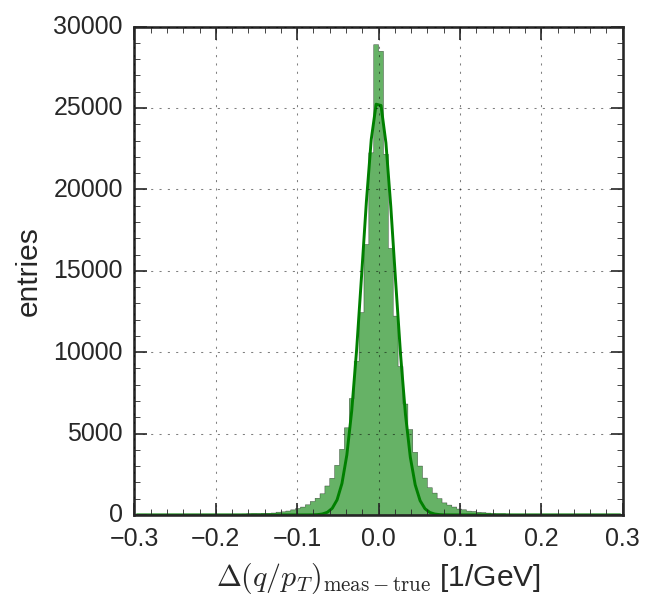

In [15]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 237357, mean: 0.149777397513, std: 0.216951608658
[INFO    ] gaus fit (a, mu, sig): [ 2.97780545e+04 -5.69131432e-03  1.14313058e-01]


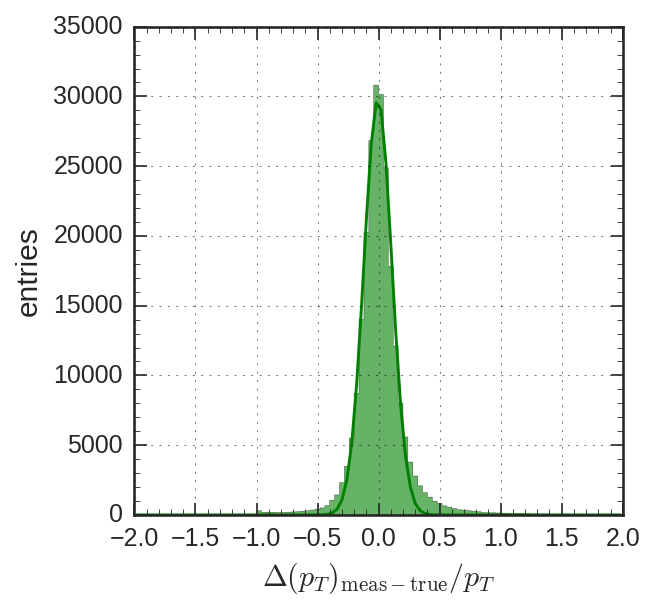

In [16]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


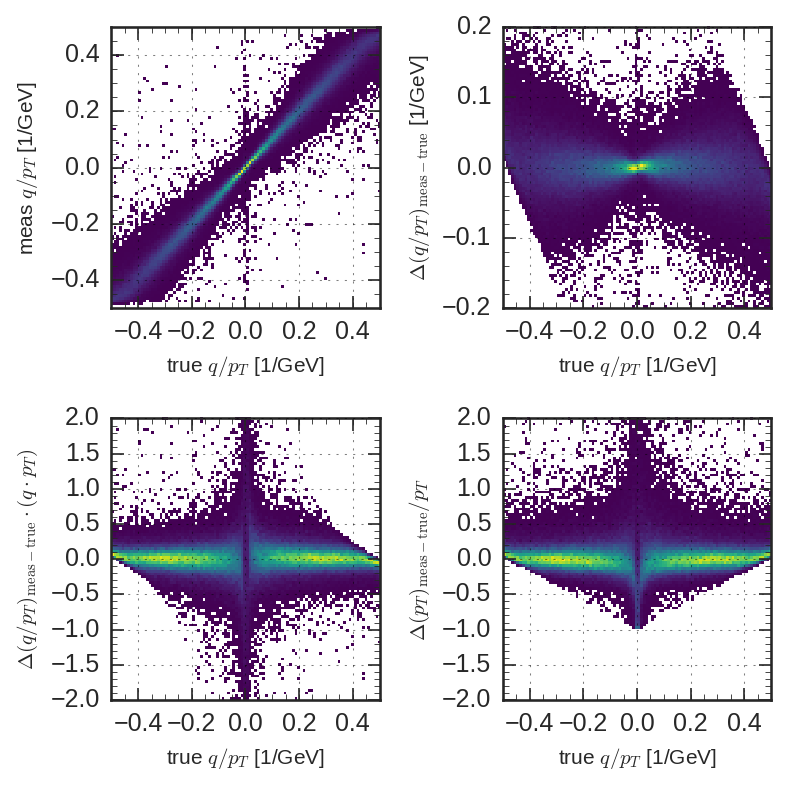

In [17]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [18]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.2)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 2.16800615e+02 -4.51046698e-02  1.80954975e-01]


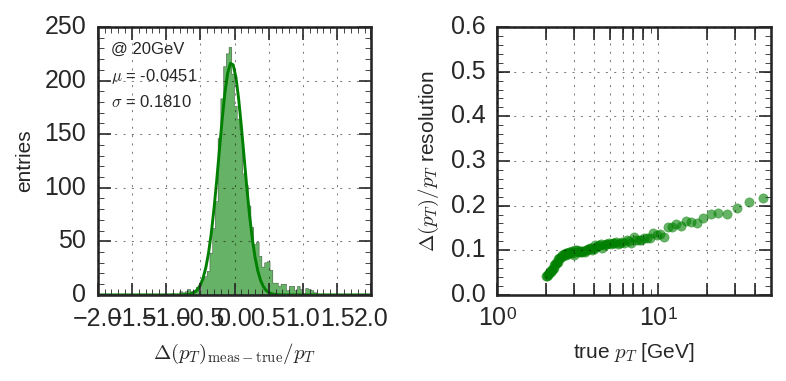

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,0.6+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

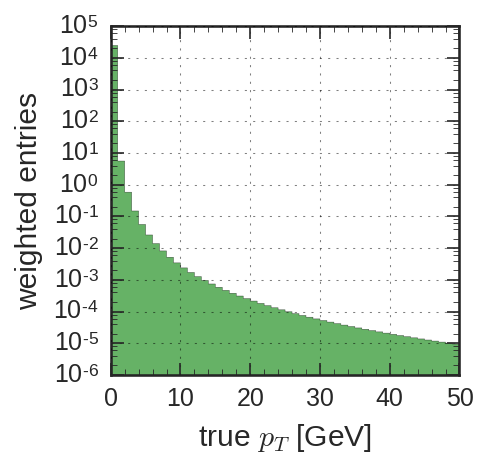

In [20]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [21]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 15.8728504181 rate 141.803390503
[INFO    ] 22 GeV threshold 17.1401062012 rate 116.708061218


### Classification Results

In [22]:
# Prepare y_test_true, y_test_meas (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
#y_test_true = [y_test_true[0], y_test_true[1]]
#y_test_meas = [y_test_meas[0], y_test_meas[1]]
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=4096)
#pu_y_test_meas = [pu_y_test_meas[0], pu_y_test_meas[1]]
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

In [23]:
# Calculate losses (1)
from nn_models import masked_huber_loss, masked_binary_crossentropy

regr_y_true = (y_test_true[0] * reg_pt_scale)[:, np.newaxis]
regr_y_pred = (y_test_meas[0] * reg_pt_scale)
assert(regr_y_true.ndim == 2 and regr_y_pred.ndim == 2)
regr_loss = K.mean(masked_huber_loss(regr_y_true, regr_y_pred))

num_samples = y_test_true[1].shape[0]
pu_num_samples = pu_y_test_true[1][pu_y_test_sel].shape[0]
index_array = np.random.randint(num_samples, size=pu_num_samples)
discr_y_true = np.concatenate((y_test_true[1][index_array], pu_y_test_true[1][pu_y_test_sel]))[:, np.newaxis]
discr_y_pred = np.concatenate((y_test_meas[1][index_array], pu_y_test_meas[1][pu_y_test_sel]))
assert(discr_y_true.ndim == 2 and discr_y_pred.ndim == 2)
discr_y_true = K.cast(discr_y_true, dtype=np.float32)
discr_y_pred = K.cast(discr_y_pred, dtype=np.float32)
discr_loss = K.mean(masked_binary_crossentropy(discr_y_true, discr_y_pred))

sess = K.get_session()
logger.info('Evaluated losses - regr_loss: {0} - discr_loss: {1}'.format(*sess.run([regr_loss,discr_loss])))

[INFO    ] Evaluated losses - regr_loss: 2.29377102852 - discr_loss: 0.00949190091342


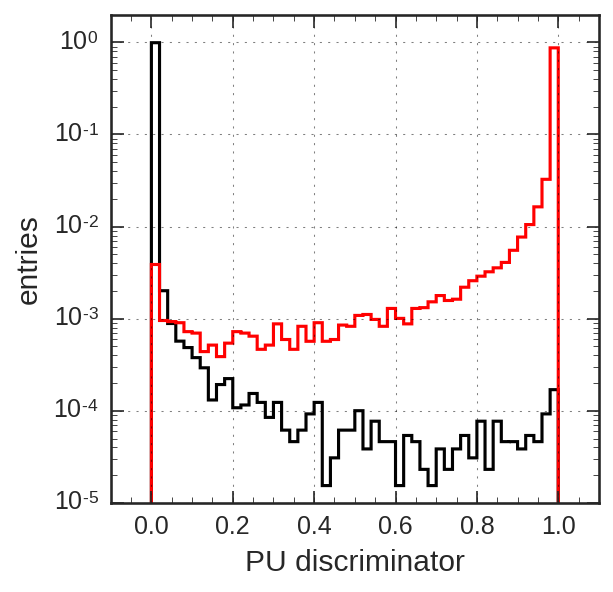

In [24]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

[INFO    ] auc: 0.994508175665
[INFO    ] thr: [0.9839, 0.9752, 0.9519, 0.9186, 0.8789, 0.8311, 0.7475, 0.5118, 0.0790]
[INFO    ] tpr: [0.9020, 0.9253, 0.9531, 0.9710, 0.9807, 0.9855, 0.9901, 0.9951, 0.9990]
[INFO    ] fpr: [0.0110, 0.0143, 0.0245, 0.0338, 0.0397, 0.0464, 0.0515, 0.0776, 0.1671]


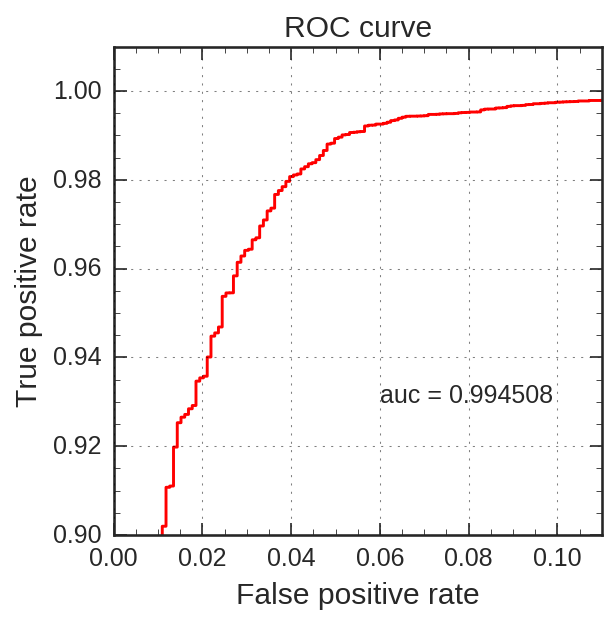

In [25]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))[:, np.newaxis]
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))

zz_tmp = np.abs(1.0/zz) > discr_pt_cut  # meas pT > 14 GeV
xx = xx[zz_tmp]
yy = yy[zz_tmp]

fpr, tpr, thresh = roc_curve(xx, yy)  # (y_true, y_meas)
auc = roc_auc_score(xx, yy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.06, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,0.11)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [26]:
# Build track producer

pt_bins = (-0.5 , -0.38, -0.26, -0.15, -0.05, 0.05, 0.15, 0.26, 0.38, 0.5)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - abs(ipt - best_ipt)

def get_zone_from_x(x):
  assert(x.shape[0] == nvariables)
  zone = x[49-1] # 49th variable out of 50
  return int(zone * 5)

def get_straightness_from_x(x):
  assert(x.shape[0] == nvariables)
  straightness = x[48-1]  # 48th variable out of 50
  return int(straightness * 4) + 4

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  valid = ~x_mask
  return int(valid.sum())
  
def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  valid = ~x_mask
  mode = 0
  if np.any([valid[0], valid[1], valid[5], valid[9], valid[11]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any([valid[2], valid[6], valid[10]]):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any([valid[3], valid[7]]):  # ME3, RE3
    mode |= (1<<1)
  if np.any([valid[4], valid[8]]):  # ME4, RE4
    mode |= (1<<0)
  return int(mode)

class TrackProducer(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[  1.7752,  1.4767,  1.5292,  1.7869,  2.1605,  2.6021,  3.1004,  3.6417,
                   4.2087,  4.7908,  5.3849,  5.9919,  6.6138,  7.2522,  7.9075,  8.5729,
                   9.2521,  9.9508, 10.6765, 11.4240, 12.1833, 12.9435, 13.7027, 14.4466,
                  15.1786, 15.9113, 16.6548, 17.4105, 18.1915, 18.9763, 19.7272, 20.4535,
                  21.2309, 22.1217, 23.0479, 23.8688, 24.6103, 25.4144, 26.2911, 27.1718,
                  28.0902, 29.0131, 29.8476, 30.6304, 31.4112, 32.2368, 33.1071, 34.1228,
                  35.3238, 36.6118, 37.9929, 39.4356, 40.7376, 41.9937, 43.2880, 44.6462,
                  46.0374, 47.6467, 49.4922, 50.6042, 51.5235, 52.4197, 53.3099, 54.1978,
                  55.0846, 55.9708, 56.8567, 57.7424, 58.6279, 59.5133, 60.3986, 61.2839,
                  62.1692, 63.0544, 63.9396, 64.8248, 65.7099, 66.5951, 67.4802, 68.3654,
                  69.2505, 70.1356, 71.0207, 71.9058, 72.7909, 73.6760, 74.5611, 75.4462,
                  76.3313, 77.2164, 78.1015, 78.9866, 79.8717, 80.7568, 81.6419, 82.5270,
                  83.4121, 84.2971, 85.1822, 86.0673, 86.9524, 87.8375, 88.7226, 89.6077,
                  90.4927, 91.3778, 92.2629, 93.1480, 94.0331, 94.9182, 95.8033, 96.6883,
                  97.5734, 98.4585, 99.3436,100.2287,101.1138,101.9989,102.8839,103.7690]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]

  def get_trigger_pt(self, x, y_meas):
    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-7)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return int(binx)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if (binx+1) >= self.s_nbins:  # check boundary
      binx = self.s_nbins-2

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, strg, ndof, trk_mode, y_meas, y_discr, discr_pt_cut=14.):
    ipt1 = strg
    ipt2 = find_pt_bin(y_meas)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)

    if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > discr_pt_cut:
        if ndof <= 3:
          trigger = (y_discr > 0.9839) # 90% coverage
        elif ndof == 4:
          trigger = (y_discr > 0.9519) # 95% coverage
        else:
          trigger = (y_discr > 0.8311) # 98.5% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger
  
  def run(self, slim_roads, variables, predictions, other_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(other_vars))

    tracks = []

    for myroad, myvars, mypreds, myother in izip(slim_roads, variables, predictions, other_vars):
      assert(len(myvars.shape) == 1)

      x = myvars
      x_mask = myother
      y_meas = np.asscalar(mypreds[...,0])
      y_discr = np.asscalar(mypreds[...,1])
      
      zone = get_zone_from_x(x)
      strg = get_straightness_from_x(x)
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)
      
      passed = self.pass_trigger(strg, ndof, mode, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
      xml_pt = np.abs(1.0/y_meas)
      pt = self.get_trigger_pt(x, y_meas)

      if passed:
        trk_q = np.sign(y_meas)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = myroad.theta_median
        trk = Track(myroad.id, myroad.hits, mode, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer()

In [27]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, y_meas, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, y_test_meas[0], y_test_meas[1], y_test_true[0])):
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed))
  
  # Debug
  if ievt < 20.:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed

0 7 3.50443519892e-06 2.93007767129 2.87032341957 2.97116422653 [ True]
1 5 6.46465593945e-07 2.28309511424 2.54924035072 2.65117287636 [ True]
2 7 0.00110067543574 3.98920690537 4.02559614182 4.23849916458 [ True]
3 8 0.000346833403455 2.77425209056 2.86176276207 2.9626326561 [ True]
4 6 0.00497102551162 2.0907088274 2.08154273033 2.23251867294 [ True]
5 8 0.0190998706967 3.68744042356 3.84914803505 4.03763389587 [ True]
6 9 0.999967694283 48.6056873818 34.3813552856 59.3032035828 [ True]
7 8 0.0184239689261 7.79032921808 8.96639537811 10.6277265549 [ True]
8 6 0.00470257271081 6.85421628763 6.68071889877 7.48905038834 [ True]
9 7 0.999947786331 134.796129768 52.8333473206 91.9678878784 [ True]
10 9 0.999966740608 18.8932107304 17.0638942719 23.1528015137 [ True]
11 7 0.999998569489 176.593487577 72.7122421265 127.157318115 [ True]
12 8 0.494550317526 5.96659061676 7.03014039993 7.9476108551 [ True]
13 7 1.6865269572e-05 3.98555791332 4.31901741028 4.58010005951 [ True]
14 8 0.9999990

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


10.0 [           nan            nan            nan            nan
 6.24240788e-04 1.00704935e-03 3.44100344e-03 1.43116640e-02
 5.00000000e-02 1.65752148e-01 5.53559498e-01 9.07098353e-01
 9.62501945e-01 9.62051282e-01 9.69991890e-01 9.75184440e-01
 9.67351874e-01 9.73157638e-01 9.64492474e-01 9.67570441e-01
 9.70377020e-01 9.72465582e-01 9.66878403e-01 9.62629446e-01
 9.63440860e-01 9.66945791e-01]
20.0 [           nan            nan            nan            nan
 1.34970981e-04 3.27876531e-04 5.18000518e-04 1.48621126e-03
 1.92901235e-03 4.03768506e-03 1.37332047e-02 5.29595016e-02
 1.73175665e-01 4.08205128e-01 6.71803190e-01 8.49429913e-01
 9.03667876e-01 9.44851147e-01 9.42493246e-01 9.53216374e-01
 9.60502693e-01 9.64956195e-01 9.61433757e-01 9.54975236e-01
 9.58709677e-01 9.59012781e-01]
30.0 [           nan            nan            nan            nan
 8.43568633e-05 2.57617274e-04 2.59000259e-04 6.60538339e-04
 5.40123457e-04 1.24236463e-03 4.60247940e-03 9.90209168e-03
 2.582

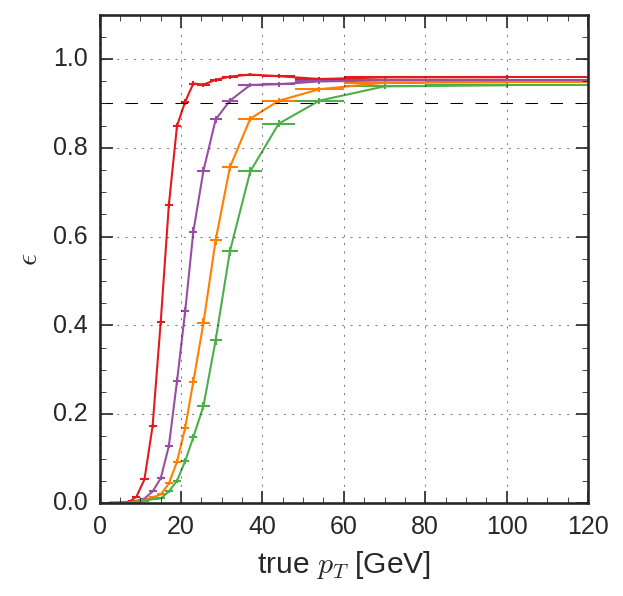

In [28]:
# Efficiency
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

eff_data = np.asarray(eff_data)

denom_hist, edges = np.histogram(eff_data[:, 1], bins=eff_pt_bins)

plt.figure()
pt_list = (10., 20., 30., 40., 50., 60.)

for pt, color in zip(pt_list, my_palette):
  passed = (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)
  eff_hist = np.true_divide(num_hist, denom_hist)

  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  print pt, ydata
  
  if pt == 10.:
    pass
  else:
    plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot(eff_pt_bins, np.full_like(eff_pt_bins,0.9), ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [29]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((4,nbinsx), dtype=np.float32)

for j in xrange(4):  # j = zone0-1, zone2-4, zone5-6, all zones
  if j == 0:
    eff_data_tmp = np.logical_or(eff_data[:,0]==0, eff_data[:,0]==1)
  elif j == 1:
    eff_data_tmp = np.logical_or(eff_data[:,0]==2, eff_data[:,0]==3, eff_data[:,0]==4)
  elif j == 2:
    eff_data_tmp = np.logical_or(eff_data[:,0]==5, eff_data[:,0]==6)
  elif j == 3:
    eff_data_tmp = (eff_data[:,0] >= 0)
    
  xx = eff_data[:,1][eff_data_tmp]  # pt_true
  yy = eff_data[:,2][eff_data_tmp]  # xml_pt
  zz = eff_data[:,4][eff_data_tmp]  # passed discr
  
  inds = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= inds) & (inds <= i+step)]
    yy_i = yy[(i <= inds) & (inds <= i+step)]
    zz_i = zz[(i <= inds) & (inds <= i+step)]
    coverage = 90  
    coverage += 1.0 # inefficiency due to fiducial cuts
    #pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    yz_i = np.where(zz_i==0, 0, yy_i)
    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    
    # Debug
    if j == 3 and discr_pt_cut <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    
    xxx[j,i] = pct

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

14.0 3.0487804878
14.5 2.7736958119
15.0 2.56510671627
15.5 2.54697286013
16.0 2.452375739
16.5 2.31687339106
17.0 2.35264982665
17.5 2.20241216571
18.0 2.43568691845
18.5 2.56032960565
19.0 2.49000922226
19.5 2.48328557784
20.0 2.58278145695
20.5 2.46613407433
21.0 2.35678027556
21.5 2.48493975904
22.0 2.37623762376
22.5 2.69485903814
23.0 2.71646859083
23.5 2.98376480913
24.0 3.12075983718
24.5 3.15634218289
25.0 2.9520295203
25.5 2.97253634895
26.0 2.9520295203
26.5 2.87517531557
27.0 2.65454545455
27.5 2.51572327044
28.0 2.26487523992
28.5 2.48350795499
29.0 2.62642101137
29.5 2.5137470542
30.0 2.44897959184


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

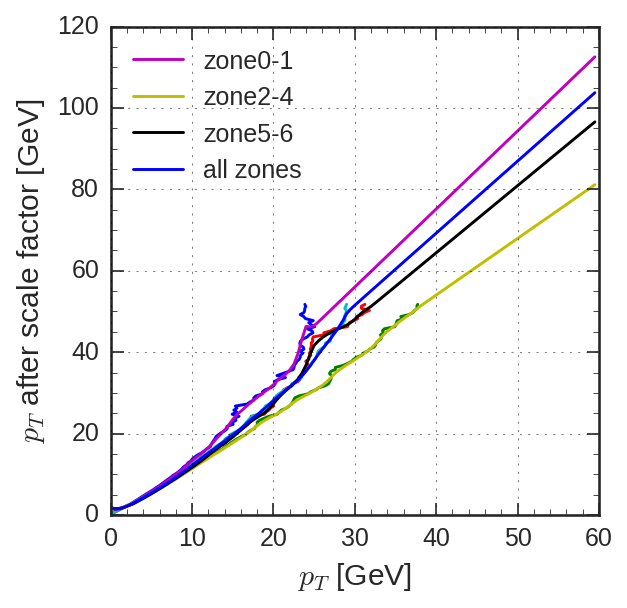

In [30]:
plt.figure()
xdata = (xedges[1:] + xedges[:-1])/2
plt.plot(xxx[0,:-16], xdata[:-16])
plt.plot(xxx[1,:-16], xdata[:-16])
plt.plot(xxx[2,:-16], xdata[:-16])
plt.plot(xxx[3,:-16], xdata[:-16])
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

xdata = xedges[:-1]
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)

line0, = plt.plot(xdata, ydata0)
line1, = plt.plot(xdata, ydata1)
line2, = plt.plot(xdata, ydata2)
line3, = plt.plot(xdata, ydata3)

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata3, separator=',', precision=4, floatmode='fixed')

def monotoically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotoically_increasing(ydata3[4:]))

plt.legend((line0, line1, line2, line3), ('zone0-1', 'zone2-4', 'zone5-6', 'all zones'), loc='upper left')
plt.show()

In [31]:
# Rates
rates_jobid_offset = 101
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, y_meas, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test)):
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  if jobid < (rates_njobs-1):
    if passed:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), ndof, pt, y_discr
    if pt > 100.:  # wtf?
      with np_printoptions(precision=3, suppress=True):
        for lay in xrange(nlayers):
          tmp = np.arange(2) * nlayers + lay
          print "....", lay, x[tmp]

  31 2826 19.5646 30.0000 6 [28.235847] [0.9984535]
  31 2937 11.6057 19.5000 7 [27.299763] [0.9751999]
  31 3675  3.0667  8.5000 4 [63.331177] [0.9996314]
  31 4581  1.5532     nan 5 [20.72267] [0.96056825]
  31 5379 18.9197 30.5000 7 [23.076004] [0.8811346]
  50 4726 11.9545     nan 6 [23.107386] [0.8860748]
  50 4898  4.9367 13.0000 7 [44.39698] [0.9696147]
  50 6191 19.5523 14.5000 6 [29.03044] [0.9763091]
  50 6191 19.5523 14.5000 6 [23.073189] [0.96660525]
  56  851  1.6143 18.5000 5 [29.149723] [0.93503827]
  56 7108 12.3301 33.0000 6 [22.476307] [0.9922792]
  60 2642 14.2474 26.0000 7 [22.057917] [0.9883238]
  60 2642 14.2474 26.0000 8 [21.731985] [0.99308103]


[INFO    ] nevents: 258400/498400


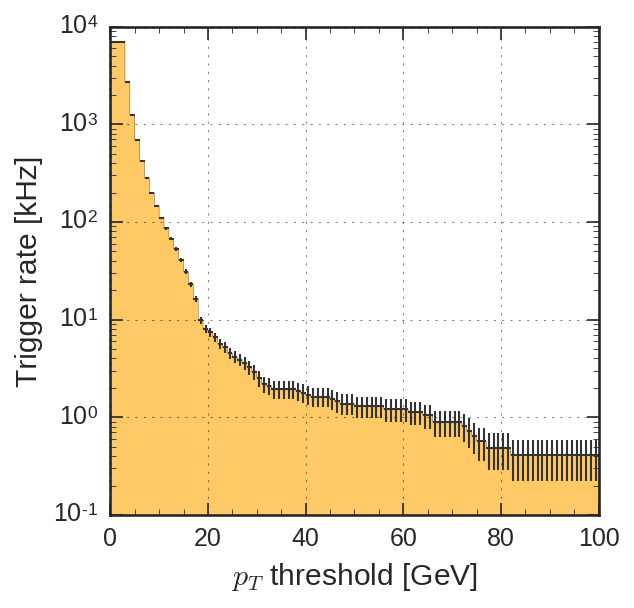

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 9.82623447478, 8.039646402, 7.47118653357, 6.57789249718, 5.68459846079


[7.0293e+03, 7.0293e+03, 7.0292e+03, 2.6960e+03, 1.2546e+03, 6.8743e+02,
 4.2472e+02, 2.8244e+02, 1.9969e+02, 1.4634e+02, 1.1044e+02, 8.6243e+01,
 6.7241e+01, 5.2948e+01, 4.0767e+01, 3.1022e+01, 2.3144e+01, 1.6323e+01,
 9.8262e+00, 8.0396e+00, 7.4712e+00, 6.5779e+00, 5.6846e+00, 5.1973e+00,
 4.5477e+00, 4.1416e+00, 3.8980e+00, 3.5732e+00, 3.2483e+00, 2.9235e+00,
 2.5175e+00, 2.1926e+00, 2.1114e+00, 1.9490e+00, 1.9490e+00, 1.9490e+00,
 1.9490e+00, 1.9490e+00, 1.8678e+00, 1.7866e+00, 1.7054e+00, 1.6242e+00,
 1.6242e+00, 1.6242e+00, 1.6242e+00, 1.5430e+00, 1.4618e+00, 1.3805e+00,
 1.3805e+00, 1.3805e+00, 1.2993e+00, 1.2993e+00, 1.2993e+00, 1.2993e+00,
 1.2993e+00, 1.2993e+00, 1.2181e+00, 1.2181e+00, 1.2181e+00, 1.2181e+00,
 1.2181e+00, 1.1369e+00, 1.1369e+00, 1.1369e+00, 1.0557e+00, 1.0557e+00,
 8.9329e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01,
 8.1209e-01, 7.3088e-01, 6.4967e-01, 5.6846e-01, 5.6846e-01, 4.8725e-01,
 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.

In [32]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11245.6
  nCollBunches = 1866
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

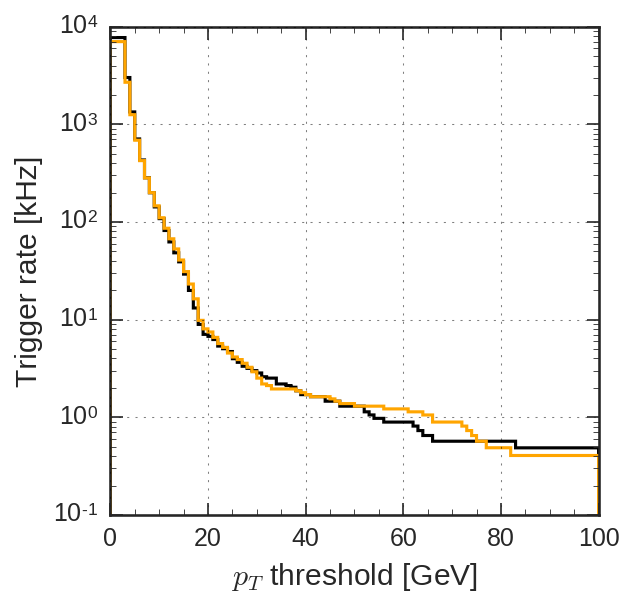

In [33]:
old_hist = [7.7367e+03, 7.7367e+03, 7.7367e+03, 3.0139e+03, 1.3394e+03, 7.0830e+02,
  4.3146e+02, 2.8350e+02, 1.9920e+02, 1.4260e+02, 1.0817e+02, 8.1777e+01,
  6.2449e+01, 4.8319e+01, 3.9061e+01, 2.9235e+01, 1.9896e+01, 1.3156e+01,
  8.9329e+00, 7.0651e+00, 6.7403e+00, 6.2531e+00, 5.3598e+00, 5.0349e+00,
  4.7101e+00, 3.9792e+00, 3.6544e+00, 3.3296e+00, 3.1671e+00, 3.0047e+00,
  2.8423e+00, 2.5987e+00, 2.5175e+00, 2.5175e+00, 2.1926e+00, 2.1926e+00,
  2.1114e+00, 2.0302e+00, 1.8678e+00, 1.7054e+00, 1.7054e+00, 1.6242e+00,
  1.6242e+00, 1.6242e+00, 1.4618e+00, 1.4618e+00, 1.4618e+00, 1.2993e+00,
  1.2993e+00, 1.2993e+00, 1.2993e+00, 1.2993e+00, 1.1369e+00, 1.0557e+00,
  9.7450e-01, 9.7450e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01,
  8.9329e-01, 8.9329e-01, 8.1209e-01, 7.3088e-01, 6.4967e-01, 6.4967e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

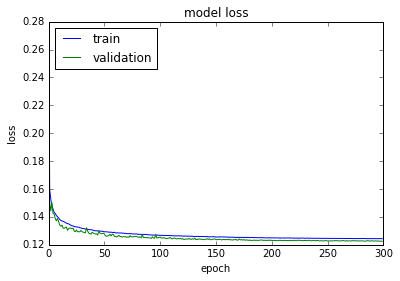

In [34]:
# Training data
# 2018-10-10

"""
[INFO    ] Done training. Time elapsed: 2:06:09.399308 sec
[INFO    ] Epoch 300/300 - loss: 0.124402610011 - regr_loss: 2.32358832844 - discr_loss: 0.00822319203379 - val_loss: 0.122574975849 - val_regr_loss: 2.29805988679 - val_discr_loss: 0.00767198009861
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAZAAAAEZCAYAAAC5AHPcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzt3Xl4VdW9//H3NyOZgIQpEAijooAKtCJONYoiapVeq1ZxaO1g26u1tZPaXxVaO+j1Wq9We+tUlVZLHarVtipWbhSt1AGBgkwyBBLCHMhAyPj9/bF3wgEDJoecHBI+r+fZT87ee+191jpHz4e11x7M3REREWmrhHhXQEREOicFiIiIREUBIiIiUVGAiIhIVBQgIiISFQWIiIhERQEichDM7FEz+2kry64xszMOdj8ihwoFiIiIREUBIiIiUVGASJcXHjr6vpktMrNyM3vYzPqa2d/NbKeZzTazHhHlLzCzxWa23czmmNlREevGmdn74XazgG77vNdnzewDMyszszfN7Jgo6/w1M1tpZlvN7Hkz6x+x7m4z2xTWYaGZjQqXn2tmS8I2rjez70b9oYm0ggJEDhcXAmcAI4HzgZeAm4A+QCJwPcGP8JHAk+F8n7Dci2aWZGbJwHPA40AO8DTw+aY3MLNxwCPA18L1DwAvhNu1WjhO8gvgIqA/sA6YFa6bDJwCjHD3HsAlwLZw04eBr7l7d2AMMKedP0ORvShA5HDxa3ff6u6lwFxgnrsvcvfaMBTGheUuAf7q7nPcvQH477CXcRIwEUhy93vdvcHdnwXejXiPrwG/dff3PPB7oCbcri2mAY+4+0J3rwNuBiaaWT5QB2QBo8zM3H25u28Kt6sFRptZlrvvdPcF7fTZibRIASKHi00Rr6tbmM8MXw8AippWeHC30WIgL1xXss9+iyJeDwa+Fx762m5mZcDAcLu22LcOVcB2IM/d/w+4D7gf2GRmvzWzprp/HjgPKDKz/zOztgaXSJsoQET2tiEMgkiDwuAoDQMhUn7E6/XAz909J5yy3T3T3f90MHUwswygV1N4uft97v5pYFR4SO4H4fL33f1z4aG3vwBPtbXxIm2hABHZ21PAeWZ2ejju8X1gN/BP4G2gzsy+Fa67EJgQse1DwDfMbALhD384sJ3Rxjr8EbjazI41s9RwPORtd19nZp82swlmlhT2nHYDjWaWbGbTzKx7eOitAmho349GZG8KEDkc7PvQm/0+BMfdVwBXhIeJtoSHhM539/pwPOJC4Opw4Ppi4NmIbd8Px0HuM7PtwArgi61538h17v4acAvw57DXMRS4LFzdPQyq7cAaYCtwZ7juSmCNme0ArgnHUkRixmL9QCkzmwL8TxhWj7j7HfusnwbcGM5WAP/p7ovCdTeH/zM3AP8Grg4HPUVEJM5i2gMxs4TwX3JnA6OByyLPqQ+tBj7j7scBPwMeDLcdHP5rbpy7HwskAZfGsr4iItJ6sT6ENQFY6e5FYfd/FjA1soC7z3P3neHsvPBsF4Dy8LTEjPB4b3o4uCgiIoeAWAdIXnhmSpPiiIBoyVfDC7dw9zLgrvAiqhJgh7v/I8b1FRGRVjpkBtHN7PRwcPLGcH4YcEN4OuMAIDMcLxERkUNAUoz3X7LPefIDW7gQCzM7Nhz7mBL2PAA+Dbzl7tvDMn8OrwZ+soXtY3smgIhIF+TudjDbx7oH8i4wwswGm1lKOAj+QmSB8PYMzwJXuvuqiFXLw9s3dDMzAyYBS/f3Ru7eJafp06fHvQ5qn9qn9nW9qT3EtAfi7g1mdh0wO+I03qVm9vXwLhEPhue75wC/CYOizt0nuPtCM5sJvB+exvtB0xlaIiISf7E+hIW7vxzebiFy2QMRr78Wnq7b0rZ3RlwkJSIih5BDZhBdWlZQUBDvKsSU2te5qX2Ht5hfid4Rgrtad/52iIh0FDPjYAfRY34IK56GDBlCUVFRK0pKRxo8eDBr166NdzVE5CB16R5ImLBxqZPsn74Xkfhrjx6IxkBERCQqChAREYmKAkRERKKiAOmkvvnNb/Lzn/883tUQkcOYBtHjZOjQoTzyyCOcccYZ8a5KhzuUvxeRw4UG0buohgY9ylpEDn0KkDi46qqrWLduHZ/97Gfp3r07d955JwkJCfzud79j8ODBTJo0CYBLLrmE/v37k52dTUFBAR9++GHzPq6++mpuvfVWAF5//XUGDRrEr371K/r160deXh6PPfZY3NonIocHBUgczJw5k/z8fP72t79RXl7OJZdcAsAbb7zBsmXLeOWVVwA499xzWbVqFZs3b2b8+PFcfvnl+93nxo0bqaioYMOGDTz88MNce+217Ny5c7/lRUQO1mEdIGbtM0UrchzAzPjJT35CWloaqampAHzpS18iPT2d5ORkbr31VhYuXEhFRUWL+0pJSeGWW24hMTGRc845h8zMTJYvXx595UREPsFhHSDu7TO1l4EDBza/bmxs5KabbmLEiBH07NmToUOHYmZs3bq1xW179epFQsKerzM9PZ3Kysr2q5yIyD4O6wCJJ2uh6xK57Mknn+TFF19kzpw57Nixg7Vr17brg2BERA6WAiROcnNzWb16NUQ8TTFSRUUFqampZGdnU1VVxc0339xi6IiIxIsCJE5uuukmbrvtNnJycnj22Wc/Fg5XXXUV+fn55OXlMWbMGE466aQ27V9hIyKxpgsJpcPpexGJP11IKCIicRPzADGzKWa2zMxWmNmNLayfZmYLw+lNMzs2Yl0PM3vazJaa2RIzOyHW9RURkdaJ6RMJzSwBuA+YBGwA3jWzv7j7sohiq4HPuPtOM5sCPAhMDNfdA/zd3S82syQgPZb1FRGR1ot1D2QCsNLdi9y9DpgFTI0s4O7z3L3pkul5QB5B+HQHTnX3R8Ny9e5eHuP6iohIK8U6QPKA9RHzxU0BsR9fBV4KXw8FtprZo2Y238weNLO0GNdXRERa6ZAZRDez04GrgaZxkiRgPHC/u48HdgE3xbmaIiISiukYCFAC5EfMDwyX7SUcOH8QmOLuZeHiYmC9u78Xzj8TES4fM2PGjObXBQUFFBQUtGMzREQ6t8LCQgoLC9t1nzG9DsTMEoHl4SB6KfAOcJm7L40okw+8Blzp7vP22f514GvuvsLMpgPp7t7SmVy6DqQT0fciEn+H/HUg7t4AXAfMBpYAs9x9qZl93cyuCYvdAuQAvzGzD8zsnYhdXA88YWYLgOOAX8Syvoe6pud+NBkzZgxvvPFGq8q2lR6ZKyKfJNaHsHD3l4GR+yx7IOL114Cv7WfbhcDxsa5jZxJ5i5LFixe3uuyBPP744zz88MPMnTu3edn//u//HkQtReRwcMgMokv8uLvunSUibaYAiYP/+q//4uKLL95r2Xe+8x2+853v8NhjjzFq1Ci6d+/OiBEjePDBB/e7n6FDhzJnzhwAdu/ezZe+9CVycnIYM2YM77777l5l77jjDkaMGEH37t0ZM2YMzz//PADLli3jm9/8Jm+//TZZWVnk5OTAPo/MBXjooYc44ogj6N27N5/73OcoLS1tXpeQkMADDzzAkUceSU5ODtddd107fVIicihTgMTBpZdeyksvvURVVRWED4966qmnmDZtGv369Wt+1O2jjz7KDTfcwIIFCz5xnzNmzGDNmjWsWbOGV155hccff3yv9SNGjOCtt96ivLyc6dOnc8UVV7Bp0yaOOuoofvvb33LiiSdSUVHB9u3bP7bvOXPm8KMf/YhnnnmG0tJS8vPzufTSS/cq87e//Y3333+fhQsX8tRTTzF79uyD/pxE5NAW8zGQQ5n9pH0O2/j0tp1RlJ+fz/jx43nuuee44ooreO2118jIyGDChAl7lTv11FOZPHkyc+fOZezYsQfc59NPP81vf/tbevToQY8ePbj++uu57bbbmtd//vOfb3598cUX84tf/IJ33nmH888//xPr++STT/KVr3yF4447DoBf/vKXZGdns27dOvLzg7O0b775ZrKyssjKyuL0009nwYIFTJ48uU2fi4h0Lod1gLT1h789XXbZZfzxj3/kiiuu4I9//CPTpk0D4KWXXuKnP/0pK1asoLGxkerqao499thP3N+GDRv2eiTu4MGD91o/c+ZM7r77btauXQtAVVXVfh+P29K+P/WpTzXPZ2Rk0KtXL0pKSpoDpF+/fs3r9ThdkcODDmHFycUXX0xhYSElJSU899xzXH755dTW1nLRRRfxwx/+kC1btlBWVsY555zTqmsm+vfvz/r1e+4aU1RU1Px63bp1XHPNNfzmN7+hrKyMsrIyRo8e3bzfTxpAHzBgwF77q6qqYtu2bXsFlogcfhQgcdK7d29OO+00rr76aoYNG8aRRx5JbW0ttbW19O7dm4SEBF566aVWjyVccskl/PKXv2THjh0UFxdz3333Na+rqqoiISGB3r1709jYyKOPPrrXKcD9+vWjuLiYurq6Fvd92WWX8eijj7Jo0SJqamr40Y9+xMSJEw/qOhMR6fwUIHE0bdo0XnvtNS6//HIAMjMzuffee7n44ovJyclh1qxZTJ06db/bR/Ycpk+fTn5+PkOHDmXKlClcddVVzeuOPvpovve97zFx4kRyc3NZsmQJp5xySvP6M844g9GjR5Obm0vfvn0/9j6TJk3itttu48ILLyQvL481a9Ywa9asFuvR0ryIdE16pK10OH0vIvF3yN/KREREui4FiIiIREUBIiIiUVGAiIhIVBQgIiISFQWIiIhEpUvfymTw4MG6JuEQtO9tVkSkc+rS14GIiEjLdB2IiIjEjQJERESiEvMAMbMpZrbMzFaY2Y0trJ9mZgvD6U0zO2af9QlmNt/MXoh1XUVEpPViGiBmlgDcB5wNjAYuM7Oj9im2GviMux8H/Ax4aJ/13wY+jGU9RUSk7WLdA5kArHT3InevA2YBe91e1t3nufvOcHYekNe0zswGAucCD8e4niIi0kaxDpA8YH3EfHFkQLTgq8BLEfN3Az8AdIqViMgh5pC5DsTMTgeuBk4J588DNrn7AjMrAA54utmMGTOaXxcUFFBQUNABtRYR6RwKCwspLCxs133G9DoQM5sIzHD3KeH8TcFRK79jn3LHAs8CU9x9VbjsF8AVQD2QBmQBf3b3q1p4H10HIiLSBu1xHUisAyQRWA5MAkqBd4DL3H1pRJl84DXgSneft5/9nAZ8z90v2M96BYiISBu0R4DE9BCWuzeY2XXA7HC85RF3X2pmXw97Ig8CtwA5wG8suO9InbtPiGW9RETk4OlWJiIihyHdykREROJGASIiIlFRgIiISFQUICIiEhUFiIiIREUBIiIiUVGAiIhIVBQgIiISFQWIiIhERQEiIiJRUYCIiEhUFCAiIhIVBYiIiERFASIiIlFRgIiISFQUICIiEhUFiIiIREUBIiIiUVGAiIhIVGIeIGY2xcyWmdkKM7uxhfXTzGxhOL1pZseEywea2RwzW2Jm/zaz62NdVxERaT1z99jt3CwBWAFMAjYA7wKXuvuyiDITgaXuvtPMpgAz3H2imeUCue6+wMwygfeBqZHbRuzDY9kOEZGuxsxwdzuYfcS6BzIBWOnuRe5eB8wCpkYWcPd57r4znJ0H5IXLN7r7gvB1JbC0aZ2IiMRfrAMkD1gfMV/8CSHwVeClfRea2RBgLPCv2FRTRETaKineFWhiZqcDVwOn7LM8E3gG+HbYE2nRjBkzml8XFBRQUFAQ4xqLiHQehYWFFBYWtus+Yz0GMjEc05gSzt8UHJHyO/YpdyzwLDDF3VdFLE8C/gq85O73HOB9NAYiItIGnWEM5F1ghJkNNrMU4FLghcgCZpYfhseVkeER+h3w4YHCQ0RE4iOmPRDC03iBe8KwesTdbzezr4c9kQfN7CHgQqAIMKDO3SeY2cnAG8C/AQ+nH7n7yy28h3ogIiJt0B49kJgHSEdQgIiItE1nOIQlIiJdlAJERESiogAREZGoKEBERCQqChAREYmKAkRERKKiABERkagoQEREJCoKEBERiYoCREREoqIAERGRqChAREQkKgoQERGJigJERESiogAREZGoKEBERCQqrQoQM/u2mXW3wCNmNt/MJse+eiIicqhqbQ/ky+5eDkwGsoErgdtjXDcRETmEtTZAmh57eC7we3dfErFMREQOQ60NkPfNbHYYIK+YWRbQ2JoNzWyKmS0zsxVmdmML66eZ2cJwetPMjm3ttiIiEj/m7p9cyCwBGAusdvcdZpYDDHT3Ra3YbgUwCdgAvAtc6u7LIspMBJa6+04zmwLMcPeJrdk2Yh/emnaIiEjAzHD3gzqS1NoeyInA8jA8rgB+DOxsxXYTgJXuXuTudcAsYGpkAXef5+5N+5oH5LV2WxERiZ/WBsj/ArvM7Djge8AqYGYrtssD1kfMF0cEREu+CrwU5bYiItKBklpZrt7d3cymAve5+yNm9pX2rIiZnQ5cDZwSzfYzZsxofl1QUEBBQUF7Vk9EpFMrLCyksLCwXffZ2jGQ14GXgS8DpwKbgYXufswnbDcxHNOYEs7fFBy18jv2KXcs8Cwwxd1XtWVbNAYiItJmHTkG8gWgJrweZCMwELizFdu9C4wws8FmlgJcCrwQWcDM8sPwuLIpPFq7rYiIxE+reiAEP/T9gOPD2XfcfXMrt5sC3BOG1SPufruZfT3sTTxoZg8BFwJF4bUlde4+YX/b7uc91AMREWmD9uiBtPYQ1iVhj6Mw/JE/FfiBuz9zMG/eXhQgIiJt05EBshA4q6nXYWZ9gH+4+3EH8+btRQEiItI2HTkGkrDPIattupOviMjhrbWn8b5sZq8AfwznvwD8PYb1EhGRQ1xbBtE/D5wczs519+diWrM20CEsEZG26bAxkEOdAkREpG3aI0AOeAjLzCqAln6ZLTwNt/vBvLmIiHReBwwQd8/quKqIiEhnojOpREQkKgoQERGJigJERESiogAREZGoKEBERCQqChAREYmKAkRERKKiABERkagoQEREJCoKEBERiYoCREREoqIAERGRqMQ8QMxsipktM7MVZnZjC+tHmtk/zWy3mX13n3U3m9kSM1tkZk+YWUqs6ysiIq0T0wAxswTgPuBsYDRwmZkdtU+xbcC3gDv32XYw8DVgnLsfG945+NJY1ldERFov1j2QCcBKdy9y9zpgFjA1soC7b3X394H6fbYtB2qBDDNLAtKBDTGur4iItFKsAyQPWB8xXxwu+0TuXgbcBawDSoAd7v6P2FVVRETa4oAPlIonMxsG3AAMBnYCz5jZNHd/sqXyM2bMaH5dUFBAQUFBR1ZXROSQVlhYSGFhYbvuM6bPRDezicAMd58Szt8UPgr3jhbKTgcq3P1X4fwlwFnu/rVw/krgBHe/roVtvbHRsYN6uq+IyOGjPZ6JHutDWO8CI8xscHgG1aXACwcoH9mY5cBEM+tmZgZMApbub8PGxvatuIiIHFhMD2G5e4OZXQfMDsPqEXdfamZfD3siD5pZP+A9IAtoNLNvA6PcfaGZzQTeBxqAD4AH9/dejY2QmBjL1oiISKSYHsLqKGbmu3c7qanxromISOfQGQ5hdZgukIMiIp1KlwkQjYGIiHQsBYiIiERFASIiIlHpMgGiMRARkY7VZQJEPRARkY6lABERkagoQEREJCpdJkA0BiIi0rG6TICoByIi0rEUICIiEhUFiIiIRKXLBIjGQEREOlaXCRD1QEREOpYCREREoqIAERGRqHSZANEYiIhIx+oyAaIeiIhIx1KAiIhIVGIeIGY2xcyWmdkKM7uxhfUjzeyfZrbbzL67z7oeZva0mS01syVmdsL+3kcBIiLSsZJiuXMzSwDuAyYBG4B3zewv7r4sotg24FvA51rYxT3A3939YjNLAtL3914aAxER6Vix7oFMAFa6e5G71wGzgKmRBdx9q7u/D9RHLjez7sCp7v5oWK7e3cv390bqgYiIdKxYB0gesD5ivjhc1hpDga1m9qiZzTezB80sbX+FFSAiIh0rpoewDlISMB641t3fM7P/AW4CprdU+L77ZpAXRlNBQQEFBQUdXF0RkUNXYWEhhYWF7bpP8xgOHpjZRGCGu08J528Kjkb5HS2UnQ5UuPuvwvl+wNvuPiycPwW40d3Pb2Fbf/55Z+rUfdeIiEhLzAx3t4PZR6wPYb0LjDCzwWaWAlwKvHCA8s2NcfdNwHozOzJcNAn4cH8brl+/vzUiIhILMT2E5e4NZnYdMDsMq0fcfamZfT3siTwY9jTeA7KARjP7NjDK3SuB64EnzCwZWA1cvb/3UoCIiHSsmB7C6ihm5tOmOU88Ee+aiIh0Dp3hEFaHUQ9ERKRjdZkAWbe+8/ekREQ6ky4TIBs21ulaEBGRDtRlAqR7Tg2bN8e7FiIih48uEyB5+TUaBxER6UBdKEBqWbMm3rUQETl8dJkAGXFUDf/+d7xrISJy+Og6ATKyhkWL4l0LEZHDR5cJkMEjdvP2jueYVzwv3lURETksdJkASexRyvaBv+f5xS/HuyoiIoeFQ/l27m2yducqUnI/4sP1veNdFRGRw0KX6YGs3LaSuszVrNpcEu+qiIgcFrpMgLxd/Db1CVWs26EAERHpCF0mQN7b8B753QdTmVDCzp3xro2ISNfXZQLEcU7KPxHrtpMX/lYT7+qIiHR5XSZA+mf254icI8hOzuXJF0vjXR0RkS6vywTI8JzhDM8ezrA+ebyxoITy8njXSESka+syAfLfZ/03F4y8gMHZeRw9oYTnn493jUREuraYB4iZTTGzZWa2wsxubGH9SDP7p5ntNrPvtrA+wczmm9kLB3qfEwaeQHZaNgOyBjD21BJmzICiovZujYiINIlpgJhZAnAfcDYwGrjMzI7ap9g24FvAnfvZzbeBD1v7nsf2O5bXqu7l7P+czbnnQkPDwbVBRERaFuseyARgpbsXuXsdMAuYGlnA3be6+/tA/b4bm9lA4Fzg4da+4VfGfYWfFvyU+T1uoVcv+P3v26spIiISKdYBkgdEPuapOFzWWncDPwBa/cBzM+OiURexeMtibrmtkh//GD1oSkQkBg7ZQXQzOw/Y5O4LAAunVklLTmNc7jhs0DxuuAHOPBM2bYptfUVEDjexvpliCZAfMT8wXNYaJwMXmNm5QBqQZWYz3f2qlgrPmDGj+XVBQQGfGfwZ3ih6g59+70zKK5zJk425c6F794NtkohI51NYWEhhYWG77tPcW310qO07N0sElgOTgFLgHeAyd1/aQtnpQKW739XCutOA77n7Bft5H9+3Ha989Aq3Ft7K8194npN/dzInL3mPuvIc/vhHsFb3ZUREuiYzw90P6tcwpoew3L0BuA6YDSwBZrn7UjP7upldQ9CIfma2HrgB+H9mts7MMg/2vScNm0RZdRmXPnsp63au46SvPMeKFfD970NjY7s0T0TksBbTHkhHaakHAvDEoif44vNf5I4z7+DlVS/z1Gdf5cILYedO+PKX4ZxzYPjwuFRZRCSu2qMH0qUDpNEbWbRpEUf2OpIBdw1g+XXL6ZPejxdfhL/+FZ57Dq69Fm64AXr2jEvVRUTi4pA/hBVvCZbA2NyxpCen89kjP8szHz5DQgJMnQoPPQTvvw9r18LIkfDoo7BrV7xrLCLSeXTpAIl06ZhLmbVk1l7LBg+Gxx8PeiNPPAG5uXD++UGwiIjIgR02ATJ5+GQ+3PIhq7avYvHmxawpW9O87vjj4R//gHXrggA591z4xjegRA83FBHZr8MmQFISU/jxqT/mvCfP46RHTuLGf3zsvo707AnXXAMffhhcL3LMMTBtGjz5JNR/7EYrIiKHty49iL4vd+f2N29naPZQvvHXb/DR9R/RO703pRWlzF41my+O/eJe5UtL4e9/D+6nNX8+DBkCZ50FeXnQq1cwlqLBdxHpjHQWVqi1ARLpij9fQc9uPRmRM4KfvfEzdtfvZtE3F5HdLZs3it5gVdkqzhx2JoO6D6K6vprU2gGsXAmvvQZbtwa3ip83DyZNgjPOgCuugOTkYN+N3sg1L17D/efeT2pSamwaLSJyEBQgoWgCZNX2VdxaeCsVNRXcceYd3POve+iV1ovHFj7GMX2PYVj2MJ7+8GkavZGjex/Nm19+82P7WLAgmGbOhLfeggED4OijYcJ5S/nJ1lH8/Jjn+fbZU8nIaMfGioi0AwVIKJoA2ddrq1/jzN+fyVfGfYWHLwjuHr92x1oqays5c+aZvP6l1xnScwi/fufX3DDxBhITEiE8LGZm1NRAcTG89x7c+8Zj/KvXdfTY9Flqn5xFXh6kp0NODpxwAlx+OYwa1S5NFxGJigIk1B4BUt9Yzxee+QK/Ofc39Mvst9e6H776Q6rrqslJy+Fnc3/G/efezzc+/Q0avZHPP/V5crrl8NAFD5FgwTkJ3/jrN+ib0Zd7/nUPy79ezPbSLKqrYcuW4BDYk09CZmZw2nDPnpCdDaV9ZzKq+4mM6X8EeXnBeMvQoZCqI2AiEgMKkFB7BMiBFO0oYuqsqawuW82si2Zx+Z8vJzczl4zkDNKT02n0RrLTsvnWhG9x8qCTOfl3J/PAZx/g7nl3My53HDeeEpzxVVFTwY7dOxiQOYglS2DbNtixA7Zvd75bkkf/+pM5cf3TFBfDmjVB4EyYALW10K8fDBwIgwYFU2IiZGUFpyAnJARjMmPGxOwjEJEuRgESinWAEB6qKttdRk5aDos2LQJgTdkaTh18KqmJqTzywSP8acmfWLJ5CbUNtZTdWMbqstWc9thpvH/N+wzqMYir/3I1Ty95mrsm38XV464mJTEFgCWblzDliSnUNtTy/Bee58RBJ7Jt1zYWFq2n6qOxZGTA5s3Bg7GaJvcggD74IHhsb8+e8KlPBWeIVVVBnz5BzwYgJSU4Lblv3z2HzkaODEJIRA5PCpBQRwRIa22q3MTSrUspGFIAwM/f+Dl3vX0XZw0/i8K1hTx7ybPMKJzB8m3LueKYK6hrrCM9OZ3SilImDZvEd17+DpkpmWyv3k5yYjJXj72a28+8fa/32LZrGymJKWSkZDB/wwdkJvdkcNZw/vCHIEwyMoIHaJWXB+VraoLXpaXBNS4NDcF8nz5BEDVNvXoFPZoePYJeT20tpKXBuHFB+GRkBNskJgZTQsKe14mJwWG5A90qv67KAhnlAAATmUlEQVShjuTE5Jh+/iLSOgqQ0KEUIC0pryln+v9NZ3z/8Vx53JUAzC+dzzMfPkNJRQkzF85k1udn8YUxX6C2oZa1O9bSI7UHyYnJTHhoAveecy/nHnFu875OePgEBnUfxJi+Y3hu2XNU1FSw8lsryU7Lbn7P6rpqUpNSm8dl9rV+fRAiZnumDRuCs8oqKoJeS0oKVFbCO+8EdzCurAx6Pbt7LGTnSd+m+3P/R2OD0dAAdXVBuIwaFZws0KtX8LdHjz1h8187x3NR1t2M7Xka3bvTPGVlBX/T0oL95+YGJx00NATb6vktIu1PARI61APkQNydxxY8xsWjLyYz5eOPQZm9ajZffeGr3HnWncxZM4dXV7/K5OGT+WDjB5SUl7DwGwv54as/pFd6L649/loG9xzM3KK5TPvzNI7tdyx/uuhPLe430r3/upclm5dw/3n3k5Sw5yGV63euJzcz92O9hu/P/j53vX0X//rqv5iQNyFsByxfDqtXByGwfXsw7dgRPH9lh63mD72GM6byesZtuofycj427doVBM/GjbB7dxA6EARMU8hE/k1PD0Knqgqqq4MTDlJSgmWjRwfX5dTXBz2w1NRgu/R0SEoKpsTEoOzYscF2FRVBO5KTgzq7B6GoAJOuSAES6swB0hpPLXmK+9+9n7OGncW5R5zL2NyxbKzcSEVNBSN7j2RN2Rom/2EyZdVljO47muVbl/Pg+Q/y/LLnefLfTzK+/3hOHnQyr615jfrGelKTUvnPT/8n7214j/5Z/fmfef/DcbnHsXXXVob0HMLizYtJSUxhU+UmGryBq469ilMHn8qyrcvIy8rjp2/8lBPyTqBvRl9+/Jkf0y8jOGvN9vmlLa0o5f537+fW027lofcf4tEFj7K9ejurrl/F7vrdFK4tJCUxhUnDJu21XdNXaRYEQGXlnpCpqNjzuro6mNLTg6mmJjjsVlERHKpzD4IiJSVYvnNnEFINDcF+m/Y9f35QNisrCK26uj2hsXNnEChNoRP5um/f4IacTftqbAz+btwYBOFRRwUnP6SmBvVct25PfZKT9/TykpOD9+/dOwiz9euD8avGxqAuPXtC//7BIUT3YLnZnm0TEoIpLS1oW2VlsF1TmKanKwTl4xQgoa4eIK1VXVfN7xf9nvOOOI+87nkQjjs8v+x55pfO54KRF5CRkkFJeQm/fPOXnDjwRBZvWcx5R5zHNZ+6hrlFc9lUtYmxuWOpqq1ibO5YNlVt4r537mPFthUM7jGY2atn09DYwF+n/ZUjf30k6cnp5GbmUlpZSn6PfAZ1H0TfjL4UDClg5sKZFO0sYnSf0Wyr3sZ3TvgOP3j1Bxzd52jeXv824/qPY03ZGi4YeQG903uzePNislKzuO746/jUgE9RtKOI19a8xp+W/Imtu7byzMXPMKTnEOaum8v80vn8x1H/weCegw/6c3OHjZWl9Mnos1cPDILgaQqIyKmuLrjZZnHxnlBpOlTXr19wt4Jly4K/NTXBj/mQIcGPf9P4Ul3dntdmwaMFPvwwOH17585gf0lJUFYWjF/t2hXs3yyoc9P2jY3BtGtXUD4zM6hTbW2wrLExCKG6uj37SEuDbt2Cv2lpQfmmQO7WLdhHVlbwt2l9UlKwj40bg8OTublBWNfVBSGVmvrxsbGcnD2h3NTmhoY97WiaUlKC942cEhOD+jQ0BJ/p7t3B59LYuKc+2dnBe6xfH6zPyAjqnZy8py5N9Yn829plkXVsCuGm3ql7sCw7O/hczYJ619UF/41067bnHwcNDXu+p8TEPeEfz2BXgIQUIB2noqaCzVWbGZ4znN31u0lJTGF+6XwGdR9E0c4itu7aSnF5MYVrC0lPTufX5/yaO966g3c3vMsTFz7Byx+9TGVtJReNuoie3XpSUl7CA+8/QKM3MqbvGEorSrn9rdtJsATqGuo4e8TZnD38bLZXb+cnr/+EI3sdyY7dOzhp0Em8uPxFTh18Kku3LGVnzU56p/dm5+6dTB05lbeL3+bHn/kxo/qM4uWPXmbn7p30Su/F31b+jaVblvKLSb8gJTGFRz54hHG547h73t1cNuYyHjr/IYrLi3n5o5dZVbaK4wccT3JiMqP6jGJY9jAM4631bzFz4Ux6pfXiUwM+xdvr3+aW026hZ7eeLNi4gDeK3mD9zvWcc8Q5nDH0DAAqaytZU7aGXXW7mg/7baraRE5aDimJKVTUVFBdX02vtF6UVJSQ3yP/Y599Q2MDZkaCJVBZW8nLH73MhUdfuN9xribV1cGhxNTUIAwaG4Mf26bA2L07+HFPTw9+9HbvDnoxlZVBQFRX7wnNpKTgx3zHjiDUMjOD/e7aFQRlY+OeH8u6uuAwpvveva6EhD09KdhTdvfuvaf6+qC+CQnBSSFpacGYWlMg1dcHAb19exDO3boFhzObQq3pB7upPpE/4vsu29+6yJNMCP+x0RQsCQlBubKy4LNr+qybwq2pRxwZTmY0jxk2fZ5NPdGkpD2fy4GmhISgvU3v0fQ5NoVR5N+WlhHegfyJJxQgoADpcmobatlUuYl+mf2aT3UGKCkvYV7xPM4feT4piSlsqNjA3KK5DOoxiNzMXLbu2kqjN/LC8hc4rt9x3PbGbVTVVVEwpIC8rDy27drGkb2OZGTvkdzzr3uoqq3iquOu4u3it7nq2Kv4/qvfZ+mWpWSlZlEwpICRvUaycNNC6hvrWbx5MWXVZWSkZJCZksk146/hg40fsGTLEsb3H88Ly18gNzOXXXW7mDJ8CgOyBvDQ/IdITkymvKacqtoqhmYPZVfdLo7sdSTLti6joqaCRm9kUI9BrNu5jgRLID05nfKacgqGFNDQ2MCInBH8e/O/qa6rZlXZKvpm9OXa46/lV2//irrGOgZ1H0RVXRUnDTyJuevmcnSfoxmfO55VZas4ceCJDM8Zzpw1c7hszGUAJCUksWDjAtKS08juls3u+t2M7D2S0opSisuLKS4vprSylPH9x3NEzhE0eiNJCUlkpmRS01DTfBjzo+0fcergU+mR2oPK2koyUzLJSNlzz55Gb2TJ5iWkJ6eT1z2PbkndqK6rZuuurfTJ6EO3pG64O7UNtaQmpbKlagtZqVl0S+rG5qrNlFaUMqbvGBq8gdfXvk7/rP4A9ErrRb/Mfs2hWVFTQVVdFbmZuTQ0NjC/dD7Dc4aTk5bT4f/dtlVTLzKyd9YUNgea6uuD68QaG/f0+iIDrulvS8ua/qalwZAhnSBAzGwK8D/hreMfcfc79lk/EngUGA/8yN1/FS4fCMwE+gGNwEPufu9+3kMBIgetrqGOmoYaMpIzPjaeA7C9ejuVtZXkZeU138qmyfqd6ympKOH4Acc3r6uuq6a4vJis1Cz6ZfTDzKiuq+axBY9xcv7JHNP3GLbu2kppZSl5WXkkJSSxvnw9g3sM5pkPnyE7LZvlW5czuu9octJyyMvK49XVrzJ71Wy+PO7LnDH0DP6w6A8Myx7GnDVzOH7A8by57k227trKuP7jKFxbyNKtSzk1/1Se+fAZenbrSX1jPUf3OZrqumoqaitITUxlVdkqBmQNYGD3gc2HIN9a/xYbKzc29wQraitIsASO7n00xeXFDOk5hDfXvUltQy2ZKZnN63PSckhNTKWqrqr5ItvSilL6Z/VvDuDt1dvJScth265tOM4xfY9h5faVNHoj+T3y2VCxgT7pfdiyawsZyRn0z+pPRU2w/23V24KLcbMGUNdQR9nuMlITU8lIyWBX3S76ZvSlpLyEYdnDSE9OZ2PlRrZVbyM1MZWh2UMprShlc9Vm+mT04ezhZ7OhYgO1DbXNhy+3VG1h8ebF9ErvxSmDTqHRG6lvrMfMMIy6xuCz2FK1hQ0VG8hMyaRnt5706NaDjOQMuiV1o2hnESu2rSA5IZkJeRPom9GXF1e8yJThU+iX2Y+lW5eSlZJFVV0Vq8tW0y2pG+U15fTN6MuI7BGsK1/HwKyB1DfWU9dYR0ZyBg3eQFpSGkf1PoqUxBTmrptL4dpC8nvkc0LeCaQkplBSUcLu+t0Myx5GTloO80vnk98jv3n7/B759EnvQ0VtBQO7D+Tk/JMP7QAxswRgBTAJ2AC8C1zq7ssiyvQGBgOfA8oiAiQXyHX3BWaWCbwPTI3cNmIfXTZACgsLKSgoiHc1Ykbt67yq66r559x/MumMSbg7lbWVbK/eTm1DLYkJiQztORQzo9EbWbktOM28b0Zfaupr2Fi5kT4ZfUiwBOYWzeWEgSdAeP+5gd0HkpOWw8bKjWyq3MRxucft9b6763dTXF5MoiU2j4EV7SgiLTmN3Mxc6hrq+GDjB9Q31tMvox+90ntRWVtJ0Y4iBmQNoF9mP0rKS/jL8r+Q3yOfHqk92Fa9jYbGBrqndue43OPYVLmJN9e9ybqF6xg9YTTujuMkJySTlZrVHOi76naxY/cOdtbspLqumur6anIzcxndZzTV9dW8U/IOa3es5ezhZzNnzRyq66s5IucIymvKSUlMYXTf0dTU19A9tTubqjaxfOtyBvUYRHF5Md2SujWHcaIlUllbyYptK6iur2biwImcPuR01u5Yy8JNC6lrqCOve17zPwi2VG1hXP9xbKjYQE19DQmWwEdlH7Fj9w6yUrIYlj2MOyffedABEnwwMZqAicBLEfM3ATfup+x04LsH2NfzwKT9rPOuavr06fGuQkypfZ2b2td5hb+bB/UbH+snEuYB6yPmi8NlbWJmQ4CxwL/at3oiIhKtQ/6RtuHhq2eAb7t7ZbzrIyIigViPgUwEZrj7lHD+prDbdEcLZacDFU1jIOGyJOCv4WGwew7wPl1zAEREJIYOdgwkqRVlDsa7wAgzGwyUApcClx2g/L6N+R3w4YHCg3b4EEREpO066jTeeyJO473dzL4e9kQeNLN+wHtAVni6biUwCjgOeAP4N+Dh9CN3fzmmFRYRkVbpEhcSiohIxzvkB9EPxMymmNkyM1thZjfGuz7twczWmtlCM/vAzN4Jl2Wb2WwzW25mr5hZj3jXs7XM7BEz22RmiyKW7bc9Znazma00s6VmNjluFW+l/bRvupkVm9n8cJoSsa7TtM/MBprZHDNbYmb/NrPr6ULfXwvt+xZd6/tLNbN/hb8lS8zsF7T39xfL60BifI1JAvBReBFiMrAAOCre9WqHdq0GsvdZdgfww/D1jcDt8a5nG9pzSngK9qJPak946PKDcGxuSPj9WrzbEEX7WrymCTi6M7UPyAXGhq8zgeXAUV3l+ztA+7rE9xfWOT38mwjMA05uz++vM/dAJgAr3b3I3euAWcDUeFeqHVgLPcOpwOPh68fDq/Y7BXd/EyjbZ/H+2nMBMMvd6919LbAy/J4PWftpHy2cEELY7k7TPnff6O4LwteVwFJgYFf5/vbTvqbr1Dr990fQrl3hy9Twd6WsPb+/zhwg7XKR4iHIgVfN7F0z+2q4rJ+7byL8jx7oG98qHrS++2nPvt9pSSf+Tq8zswVm9nDEIYJO276Ii3nnHeC/x67QvqaLlbvE92dmCWb2AbARKHT3D9vz++vMAdJVnezu44FzgWvN7NQwVCJ1tTMfulp7fgMMc/ex4f+4d8W7QgejhYt5u9R/jy20r8t8f+7e6O7jwp7jqWZW0J7fX2cOkBIg8qEJA8NlnZq7l4Z/t4T3/5oAbApPd266yeTmeNfzIO2vPSXAoIhynfI7dfct4b2GAB6KOAzQ6doXXsz7DPB7d/9LuLjLfH8tta8rfX9N3L0c+Dvw6fb8/jpzgDRfpGhmKeFFii/Eu1IHw8zSw38NYWYZwOTwOpgXgC+Fxb4I/OXAezrk2D7HlPfXnheAS80sxcyGAiOAd+JQ37baq33h/5RNLgQWh687Y/taupi3K31/H2tfV/n+zKx30+E3M0sDzgoHydvv+4v3WQIHeYbBlPDMiZXATfGuTzu0Z2h4NtkHYXDcFC7PAf4RtnU20DPedW1Dm54Mb+VfA6wDrgay99ce4Obw7I+lwOR41z/K9s0EFoXf5fPhMedO177wjJ2GiP8m54f/z+33v8cu0r6u8v0dE7bpA2Ah8H3/hN+TtrZPFxKKiEhUOvMhLBERiSMFiIiIREUBIiIiUVGAiIhIVBQgIiISFQWIiIhERQEiEkdmdpqZvRjveohEQwEiEn+6GEs6JQWISCuY2eXhw3nmm9n/hnc5rTCzX5nZYjN71cx6hWXHmtnb4d1cn424ncTwsNwCM3svvF0EQJaZPR0+xOf3cW2oSBsoQEQ+gZkdBXwBOCm8U3IjcDmQDrzj7mOAN8IHERE+Y+EH4d1cF0csfwL4dbj8JKA0XD4WuD58oM9wMzspTk0VaZOkeFdApBOYBIwH3jUzA7oBm8IgeSos8wfgWTPrDvQIHzRFGCZPhTfJzHP3FwjuQVdLEE6EIVQazi8Inwb3zzi1VaTVFCAin8yAx939/+210OyWfcp5RPm2qIl43aD/L6Wz0CEskU/2GnCRmfUhCI5sM8sPnzN9UVjmcuDN8LkL283s5HD5lcDr4YOK1pvZ1HAfKeEttkU6Lf1LR+QTuPtSM/sxMNvMEoBa4DqgCpgQ9kQ2heMkhM9YeCAMiNXhLd4Jw+RBM/tpuI+LW3q7DmyayEHR7dxFomRmFe6eFe96iMSLDmGJRE//+pLDmnogIiISFfVAREQkKgoQERGJigJERESiogAREZGoKEBERCQqChAREYnK/wfDMJVWHNGV0wAAAABJRU5ErkJggg==")

In [35]:
if False:
  import nn_encode
  reload(nn_encode)
  import nn_data
  reload(nn_data)
  from nn_encode import Encoder
  from nn_data import muon_data_split

  #adjust_scale = 0
  adjust_scale = 3
  reg_pt_scale = 1.0
  correct_for_eta = True
  
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.9, correct_for_eta=correct_for_eta)

  if not isinstance(y_train, list):
    y_train = [y_train]

In [36]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  #print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    if adjust_scale == 0:
      _range = None
    else:
      _range = [[xmin, xmax], [ymin, ymax]]
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=_range, cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, x_i.size, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [37]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)
  
  y_train_stdev = np.std(y_train[0]/reg_pt_scale)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    assert(np.isfinite(x_i).all())
    
    nentries_test = 120000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= y_train_stdev
    #y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1,2,3,4) or lay in (9,10,11,):  # ME1/1, ME1/2, ME2, ME3, ME4, GE1/1, GE2/1, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (5,6):  # RE1, RE2
          coef = 1.0/np.std(x_i)
        else:  # RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [38]:
if False:
  # Check loss functions
  from keras.losses import mean_squared_error, mean_absolute_error
  
  def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)
  
  def asymmetric_huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    x2 = K.abs(y_true) - K.abs(y_pred)  # x2 >= 0: underprediction of 1/pT -> overprediction of pT
    xx = tf.where(tf.logical_or(x < delta, x2 >= 0), squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

  nentries_test = x_test.shape[0]//100

  # Prepare y_test_true, y_test_meas
  y_test_true = y_test
  if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
  y_test_true = y_test_true[:nentries_test].copy()
  y_test_true = y_test_true.reshape(-1)
  #y_test_true /= reg_pt_scale

  y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
  if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
  y_test_meas = y_test_meas.reshape(-1)
  #y_test_meas /= reg_pt_scale
  
  sess = K.get_session()
  diff = y_test_true - y_test_meas
  mask = np.abs(y_test_true) - np.abs(y_test_meas) > 0.
  
  loss1 = mean_squared_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss2 = mean_absolute_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss3 = huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss4 = asymmetric_huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  
  plt.figure()
  #plt.scatter(diff, loss1, c='r', s=2, edgecolors='none')
  #plt.scatter(diff, loss2, c='g', s=2, edgecolors='none')
  #plt.scatter(diff, loss3, c='b', s=2, edgecolors='none')
  plt.scatter(diff[mask], loss4[mask], c='magenta', s=2, edgecolors='none')
  plt.scatter(diff[~mask], loss4[~mask], c='cyan', s=2, edgecolors='none')
  #plt.legend(['mse', 'mae', 'huber', 'asym huber #1', 'asym huber #2'])
  plt.xlim(-5,5)
  plt.ylim(-1,11)
  plt.show()
  
  print y_test_true.shape, y_test_true, y_test_meas, diff, np.percentile(diff, [25,50,75], overwrite_input=True)

In [39]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()